In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from astroML.plotting import hist
from astroML.plotting.mcmc import plot_mcmc
from astroML.plotting import setup_text_plots
import pymc
setup_text_plots(fontsize=8, usetex=True)

%matplotlib inline

### This Cell Defines Various Necessary Functions

In [88]:
### Modeled after AstroML book figure 10.25

# Define the function from which to generate the data
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

# Define the exponential burst profile
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

# Define a function that calculates and prints the BIC for each model
def Print_BIC(Gauss_ChiSq,Exp_ChiSq,N):
    print('\n================ Model BIC Information ===============')
    print('For N=%i Data Points:' %N)
    print('BIC for Gaussian Profile: %.1f' %(Gauss_ChiSq+4*np.log(N)))
    print('BIC for Exponential Profile: %.1f' %(Exp_ChiSq+4*np.log(N)))
    print('=======================================================')


In [93]:
def Run_Gaussian_Exponential_Comparison(N,b0_true=10,A_true=3.0,sigma_true=3.0,T_true=40):
    ''' 
    This function runs the model comparizon between a Gaussian Profile and an Exponential Profile.
    The Data is generated from a Gaussian Profile with N data points
    
    INPUT:  N                                       <- Number of Data Points
            b0_True, A_true, sigma_true, T_true     <- OPTIONAL: True values of the distribution from which data is generated
    OUTPUT: t_obs, y_obs, err_y                     <- Observed Randomly Generated Time, Flux and Flux Error values
            Gauss_Trace, Gauss_Fit                  <- MCMC Trace, Best-Fit Parameters for Gaussian Model
            Exp_Trace, Exp_Fit                      <- MCMC Trace, Best-Fit Parameters for Exponential Model
    '''
    # Set a fixed random seed
    np.random.seed(42)
    
    #========================================================================================
    #                            Generate N Data Points
    #========================================================================================    

    err0_y = 0.5

    # Add noise and calculate the "observed" flux values
    t_obs = 100 * np.random.random(N)
    y_true = GaussAndBkgd(t_obs, b0_true, A_true, sigma_true, T_true)
    err_y = 0.5*np.sqrt(y_true/10) +np.random.uniform(0, 2*err0_y)
    y_obs = np.random.normal(y_true, err_y) # Observed flux values
    
    
    #========================================================================================
    #                            Run Gaussian MCMC Chain
    #========================================================================================
    
    # Set up MCMC sampling for Gaussian MCMC parameters
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


    # uniform prior on log(alpha)
    @pymc.deterministic
    def sigma(log_sigma=log_sigma):
        return np.exp(log_sigma)


    @pymc.deterministic
    def y_model(t=t_obs, b0=b0, A=A, sigma=sigma, T=T):
        return GaussAndBkgd(t, b0, A, sigma, T)

    y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

    # Run the MCMC sampling
    def compute_Gaussian_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

        return traces, fit_vals

    # Save the traces and best-fit values for the Gaussian profile
    Gaussian_traces, Gaussian_fit_vals = compute_Gaussian_MCMC_results()
    
    
    #========================================================================================
    #                            Run Exponential MCMC Chain
    #========================================================================================
    
    # Set up MCMC sampling for exponential free parameters
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


    # uniform prior on log(alpha)
    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return np.exp(log_alpha)


    @pymc.deterministic
    def y_model(t=t_obs, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model, y=y)

    # Run the MCMC sampling
    def compute_Exponential_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals

    # Save the traces and best-fit values for the exponential profile
    Exponential_traces, Exponential_fit_vals = compute_Exponential_MCMC_results()
    
    return(t_obs,y_obs,err_y,Gaussian_traces, Gaussian_fit_vals, Exponential_traces, Exponential_fit_vals)



def Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                         Gaussian_traces,Gaussian_fit_vals,
                                         Exponential_traces,Exponential_fit_vals):
    ''' 
    This Function plots the comparison of the Gaussian Burst Model and the Exponential Burst Model
    It uses the outputs from Run_Gaussian_Exponential_Comparison()
    '''
    # Plot the initial data and two models
    plt.figure(figsize=[9,9])

    # We need a very fine grid in t for the models because the exponential profile can be very peaked
    t = np.linspace(0,100,100001)
    Gauss_y_fit = GaussAndBkgd(t, *Gaussian_fit_vals)
    Exp_y_fit = burst(t, *Exponential_fit_vals)

    # Plot the data with errors
    plt.scatter(t_obs, y_obs, s=9, lw=0, c='k')
    plt.errorbar(t_obs, y_obs, err_y, fmt='.', lw=1, c='k')

    # Plot the Gaussian fit
    plt.plot(t,Gauss_y_fit,lw=5)

    # Plot the exponential fit
    plt.plot(t,Exp_y_fit,lw=5)

    # Set limits, labels, and legend
    plt.ylim([5,15])
    plt.xlabel('Time',fontsize=16)
    plt.ylabel('Flux',fontsize=16)
    plt.title('Gaussian/Exponential Burst Model Comparison',fontsize=20)
    plt.legend(['Gaussian Fit','Exponential Fit','Observed Data'],fontsize=16)

### Plot the data and best-fit models for N=100 Points

 [-----------------100%-----------------] 25000 of 25000 complete in 4.1 sec
================ Model BIC Information ===============
For N=100 Data Points:
BIC for Gaussian Profile: 100.5
BIC for Exponential Profile: 159.0


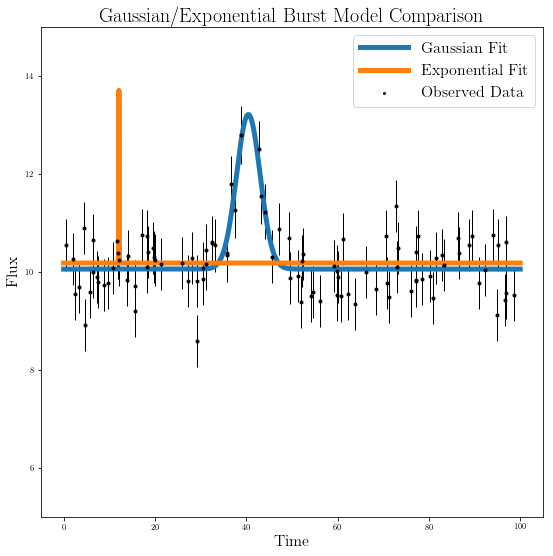

In [94]:
# Run the model comparison MCMC chains
N = 100 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Exponential_traces,Exponential_fit_vals\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

We can see from the BIC of each model that the Gaussian Profile fits better.

### Plot the data and best-fit models for N=200 Points


 [-----------------100%-----------------] 25000 of 25000 complete in 4.5 sec
================ Model BIC Information ===============
For N=200 Data Points:
BIC for Gaussian Profile: 209.9
BIC for Exponential Profile: 257.0


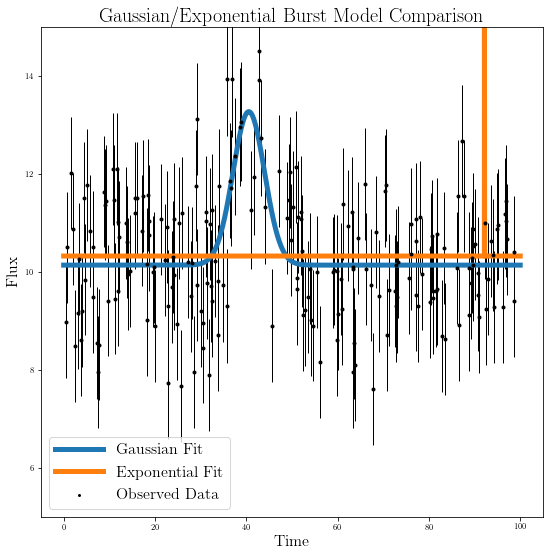

In [98]:
# Run the model comparison MCMC chains
N = 200 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Exponential_traces,Exponential_fit_vals\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

With 200 points, we can still use the BIC to see that the Gaussian Profile is better

### Plot the data and best-fit models for N=50 Points


 [-----------------100%-----------------] 25000 of 25000 complete in 5.2 sec
================ Model BIC Information ===============
For N=50 Data Points:
BIC for Gaussian Profile: 63.6
BIC for Exponential Profile: 59.1


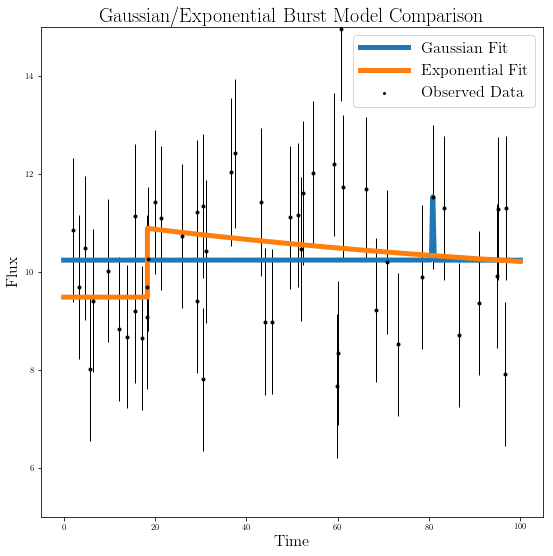

In [100]:
# Run the model comparison MCMC chains
N = 50 # Number of data points to generate

t_obs,y_obs,err_y,\
Gaussian_traces,Gaussian_fit_vals,Exponential_traces,Exponential_fit_vals\
= Run_Gaussian_Exponential_Comparison(N)

Plot_Gaussian_Exponential_Comparison(t_obs,y_obs,err_y,
                                     Gaussian_traces,Gaussian_fit_vals,
                                     Exponential_traces,Exponential_fit_vals)

# Print the BIC for each model
y_Gauss_fit = GaussAndBkgd(t_obs,*Gaussian_fit_vals)
y_Exp_fit = burst(t_obs,*Exponential_fit_vals)
Gauss_ChiSq = np.sum(((y_obs-y_Gauss_fit)/err_y)**2)
Exp_ChiSq = np.sum(((y_obs-y_Exp_fit)/err_y)**2)

Print_BIC(Gauss_ChiSq,Exp_ChiSq,N)

With only 50 points, however, we cannot tell which model is better based on the BIC